**Draft Model for Mice Steep Stage Analysis**

In [72]:
import random
import numpy as np
import pandas as pd
import os
import re
import copy
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
from torchvision import transforms, datasets, models

from collections import OrderedDict

import torch.utils.data as utils

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

import tkinter as tk #tk for file dialog (requires Jinja2!!!)
from tkinter import filedialog #tkinter for file dialog

import re #regex for parsing
from os.path import exists


In [2]:
from inputMassager import *
inputHandler = inputMassager()

filepath = inputHandler.askForInput("Blah!")

#Period Size Variable : effects CNN architecture
periodSize = 200
num_periods = 60000

#makePeriodFromTxt(self, filepath, periodSize, maxPeriods=None):
periods = makePeriodFromTxt(filepath, periodSize, num_periods)


# target = regan and audreys code ---> This is what will go into the data loader
filepath2 = inputHandler.askForInput("Blah!")
timestamps = find_time_labels(filepath2)
labels, _, _ = label_dataframe_new(periods, timestamps, periodSize)


Make a tensor out of eeg data (c1)

In [3]:
def getChannelTensors():
    #The tensor has to be 3 dimesional with the second dimesion equal to one in order to pass it through a 1d convolutional layer
    c1_tensor = torch.zeros((len(periods.c1.values), 1, periodSize)) 
    c2_tensor = torch.zeros((len(periods.c2.values), 1, periodSize)) 
    for i in range(len(periods.c1.values)):
        c1_tensor[i, 0] = torch.tensor(periods.c1.values[i])
        c2_tensor[i, 0] = torch.tensor(periods.c1.values[i])
    
    return c1_tensor, c2_tensor

eeg_samples, emg_samples = getChannelTensors()

Make the train and validation data loaders  

In [43]:
#print(eeg_samples)
print(torch.tensor(labels))

ds = torch.utils.data.TensorDataset(eeg_samples, torch.tensor(labels))
train_dataset, val_dataset = torch.utils.data.random_split(ds, [int(len(ds) *.80), int(len(ds) *.2)])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

tensor([4, 2, 2,  ..., 2, 2, 2])


/var/folders/dg/6gzrkj09311g91kn90n1qdcc0000gn/T/ipykernel_41322/330330635.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(labels))
/var/folders/dg/6gzrkj09311g91kn90n1qdcc0000gn/T/ipykernel_41322/330330635.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds = torch.utils.data.TensorDataset(eeg_samples, torch.tensor(labels))


In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Creating class for Model**

In [45]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.

        # batch_first=True
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu')
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        # print('size of x', x.size())
        h = self.rnn(x)[0]
        # print('shape of h', h.shape())
        x = self.linear(h)
        return x

In [107]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx, (data, target) in enumerate(train_data_gen):
        data, target = data.to(device), target.to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.

        # print('hi', output.size())
        # print(target.size())

        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤

        y_pred = output.argmax(dim=1)
        num_correct += y_pred.eq(target.data.view_as(y_pred)).cpu().sum().item()

    return num_correct, loss.item()

In [111]:
def test(model, test_data_gen, criterion, device, confidence_level):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    predictions = []
    label_list = []

    # Store the number of sequences that were classified correctly
    num_correct = 0
    loss = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_data_gen):

            data, target = data.to(device), target.to(device)

            output = model(data)

            output = output[:, -1, :]

            # y_pred = output.argmax(dim=1)

            loss += torch.sum(criterion(output, target)).item()

            pred_value, y_pred = output.data.max(1, keepdim=True) # get the index of the max log-probability   

            for i in range(len(target)): 
                if 4 in target[i]:
                    target[i] = 4
                    y_pred[i] = 4
                
                #if the predicted value is lower that the confidence level, set the predicted value to 0 and the target value to 0
                if pred_value[i] < confidence_level:
                    y_pred[i] = 4
                    target[i] = 4
                        
                predictions.append(y_pred[i].item())
                label_list.append(target[i].item())

            # print((y_pred == target).sum().item())
            num_correct += y_pred.eq(target.data.view_as(y_pred)).cpu().sum().item()

    return num_correct, loss, predictions, label_list

In [123]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, confidence_level, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'acc': []}
    history_test = {'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss, preds, true_labels = test(model, test_data_gen, criterion, device, confidence_level)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['acc'].append(accuracy)

        """fix this calculation"""

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=1, figsize=(9, 4.5))
    for metric in ['acc']:
        axes.plot(history_train[metric])
        axes.plot(history_test[metric])
        axes.set_xlabel('epoch', fontsize=12)
        axes.set_ylabel(metric, fontsize=12)
        axes.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model, preds, true_labels

[Epoch 1/10] acc: 64.58% - test_acc: 69.77%
[Epoch 2/10] acc: 74.33% - test_acc: 78.08%
[Epoch 3/10] acc: 77.04% - test_acc: 79.15%
[Epoch 4/10] acc: 77.86% - test_acc: 79.71%
[Epoch 5/10] acc: 79.47% - test_acc: 81.95%
[Epoch 6/10] acc: 81.91% - test_acc: 84.45%
[Epoch 7/10] acc: 84.16% - test_acc: 86.14%
[Epoch 8/10] acc: 85.62% - test_acc: 87.66%
[Epoch 9/10] acc: 86.70% - test_acc: 88.58%
[Epoch 10/10] acc: 87.21% - test_acc: 88.91%


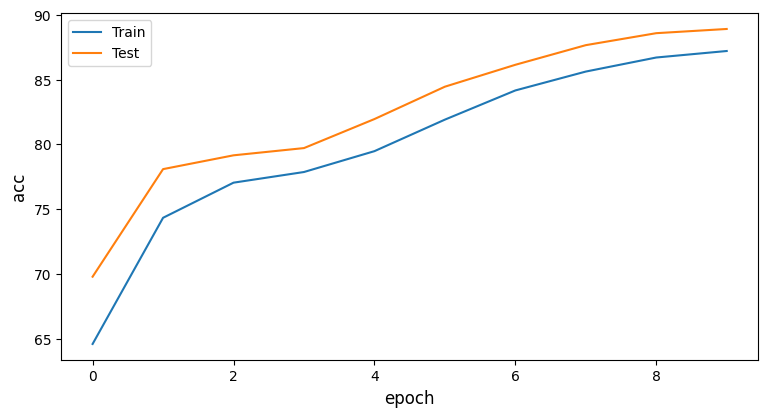

In [124]:
# Setup the RNN and training settings

# doing len(train_dataset) gives the number of batches

#rows, columns = train_dataset.get_shape()
input_size  = periodSize
hidden_size = 50
output_size = 5
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10
confidence = -0.5

# Train the model
#train(model, train_loader, criterion, optimizer, device)
best_model, predictions, label_list = train_and_test(model, train_loader, val_loader, criterion, optimizer, max_epochs, confidence, verbose=True)

In [114]:
from sklearn.metrics import classification_report
target_names = ['REM', 'Non-REM', 'Wake', 'Artifact']
print('Testing Report for RNN with EEG signals')
print('------------------------------------------------------------------------------------------------')
print(classification_report(label_list, predictions, labels=[1,2,3,4], target_names=target_names))


Testing Report for RNN with EEG signals
------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         REM       0.02      0.00      0.00       437
     Non-REM       0.33      0.04      0.07      3773
        Wake       0.64      0.95      0.77      7651
    Artifact       0.60      1.00      0.75       139

    accuracy                           0.63     12000
   macro avg       0.40      0.50      0.40     12000
weighted avg       0.52      0.63      0.52     12000

